In [31]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(tidymodels)
library(digest)
library(repr)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)
options(warn=-1)

In [3]:
urlfile <-"https://raw.githubusercontent.com/ShahrukhP15/DSCI100_GroupProject_113/main/Heart_Disease_Prediction.csv"
heart_data <- read_csv(urlfile)

#Tidying Data

heart_data <- heart_data |> 
             select(Age,Sex,BP,Cholesterol,`ST depression`,`Heart Disease`) |>
             mutate(`Heart Disease` = as_factor(`Heart Disease`), Sex= as_factor(Sex))
head(heart_data)


Rows: 270 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (13): Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, EKG resu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,BP,Cholesterol,ST depression,Heart Disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
70,1,130,322,2.4,Presence
67,0,115,564,1.6,Absence
57,1,124,261,0.3,Presence
64,1,128,263,0.2,Absence
74,0,120,269,0.2,Absence
65,1,120,177,0.4,Absence


In [32]:
#Creating Training Data And Exploratory Data Analysis

set.seed(2022);

heart_split <- initial_split(heart_data, prop = 3/4, strata = `Heart Disease`)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

#summary of training data
num_obs <- nrow(heart_train)
heart_train |>
  group_by(`Heart Disease`) |>
  summarize(
   count = n(),
   percentage = n() / num_obs * 100,
   avg_BP = mean(BP),
   avg_cholesterol = mean(Cholesterol),
   avg_ST_depression = mean(`ST depression`))
options(warn=0)

Heart Disease,count,percentage,avg_BP,avg_cholesterol,avg_ST_depression
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Presence,90,44.55446,134.5778,253.2556,1.6933333
Absence,112,55.44554,129.0893,244.0536,0.5473214


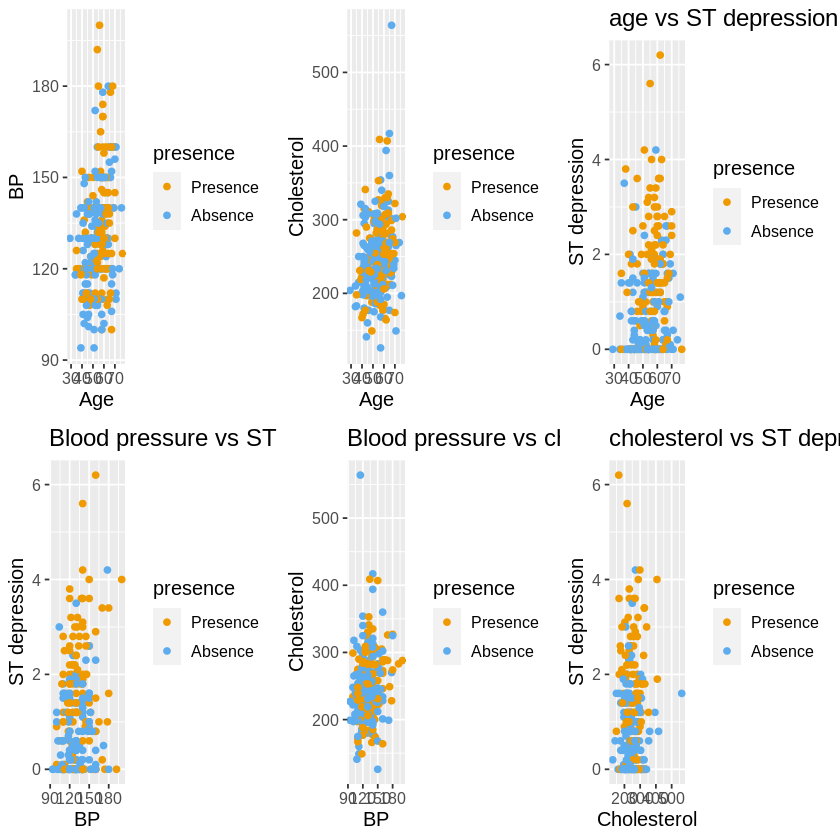

In [12]:
# making the best knn model base on different 4 variables(age, blood pressure, cholestrol, ST depression)
# separate into 6 model (age, blood pressure)(age, cholestrol)(age, ST depression)(blood pressure, ST depression)(blood pressure, cholestrol)
#(cholestrol,ST depression) 

age_blood <-heart_data |>
  ggplot(aes(x = Age, y = BP, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

age_c <-heart_data |>
  ggplot(aes(x = Age, y = Cholesterol, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))
age_ST <-heart_data |>
  ggplot(aes(x = Age, y = `ST depression`, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("age vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

BP_ST <-heart_data |>
  ggplot(aes(x = BP, y = `ST depression`, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("Blood pressure vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

BP_CH <-heart_data |>
  ggplot(aes(x = BP, y = Cholesterol, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("Blood pressure vs cholesterol")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))

CH_ST <-heart_data |>
  ggplot(aes(x = Cholesterol, y = `ST depression` , color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("cholesterol vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 12))
#plot six graph together
plot_grid(age_blood,age_c,age_ST,BP_ST,BP_CH,CH_ST)
options(warn=-1)

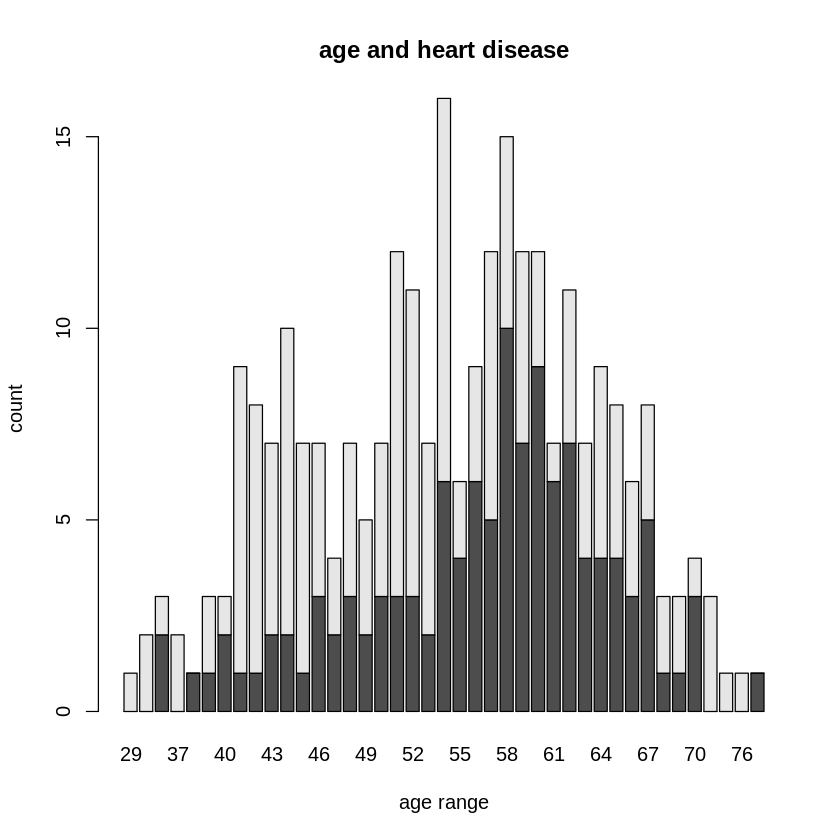

In [13]:
table1 <-table(heart_data$`Heart Disease`,heart_data$Age)
# a bar plot to see the trend line between age and disease
barplot(table1,
        beside = FALSE, 
        main = "age and heart disease",
        xlab = "age range",
        ylab= "count")
options(warn=0)

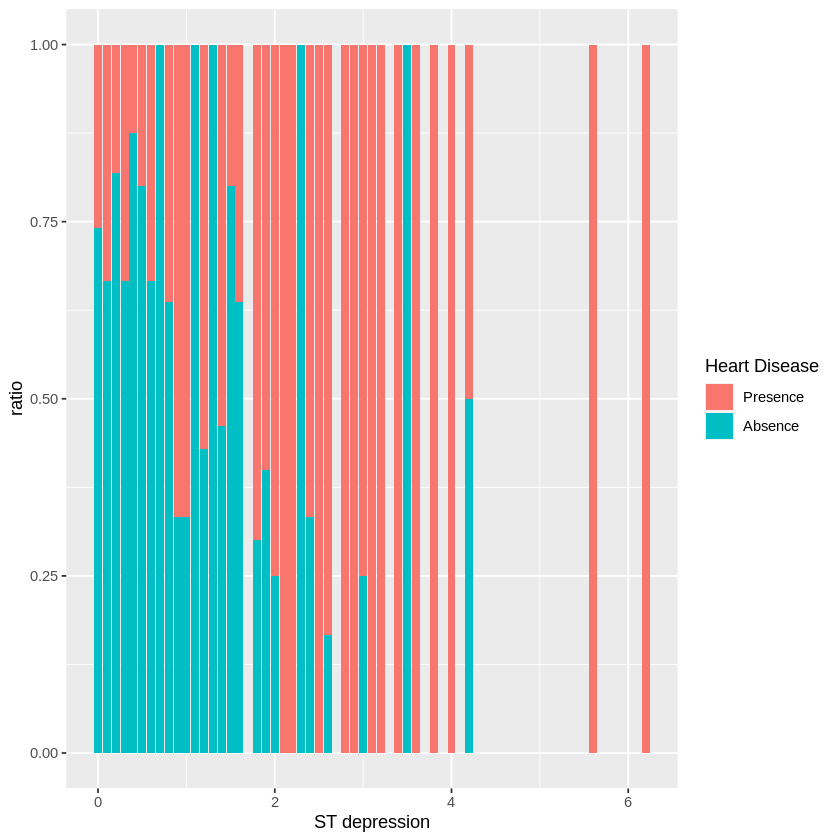

In [9]:
# different ages contains different amount of data, make it in proportion to clarify the trend
age_graph <- ggplot(data = heart_data, aes(x = `ST depression`, fill = `Heart Disease`)) + 
  geom_bar(position = "fill")+ylab("ratio")
age_graph

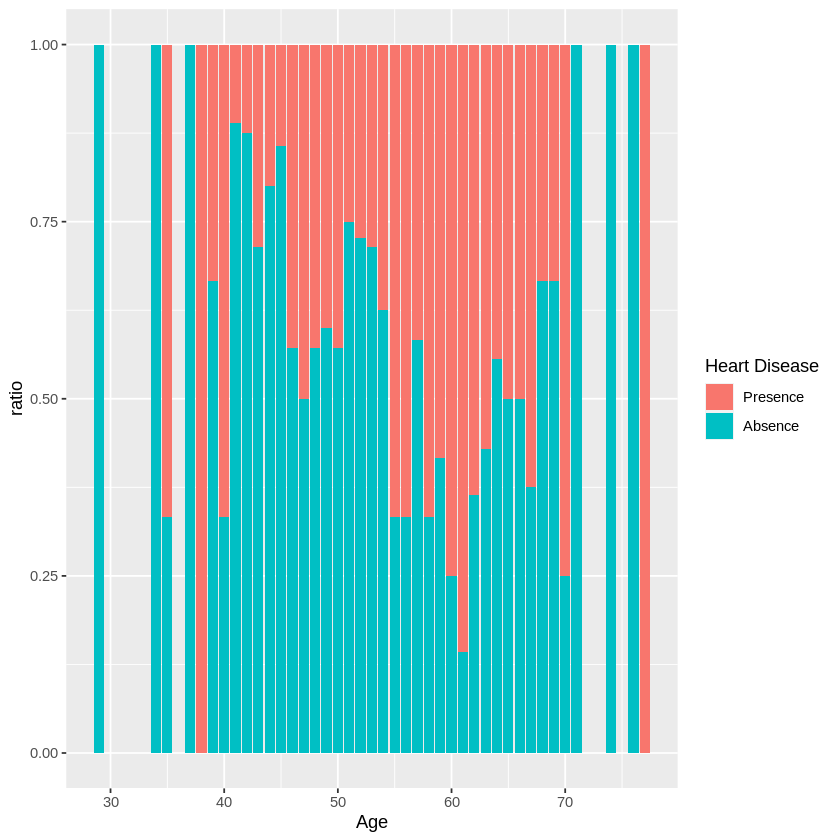

In [14]:
# the ST depression in proportion 
st_graph <- ggplot(data = heart_data, aes(x = Age, fill = `Heart Disease`)) + 
  geom_bar(position = "fill")+ylab("ratio")
st_graph

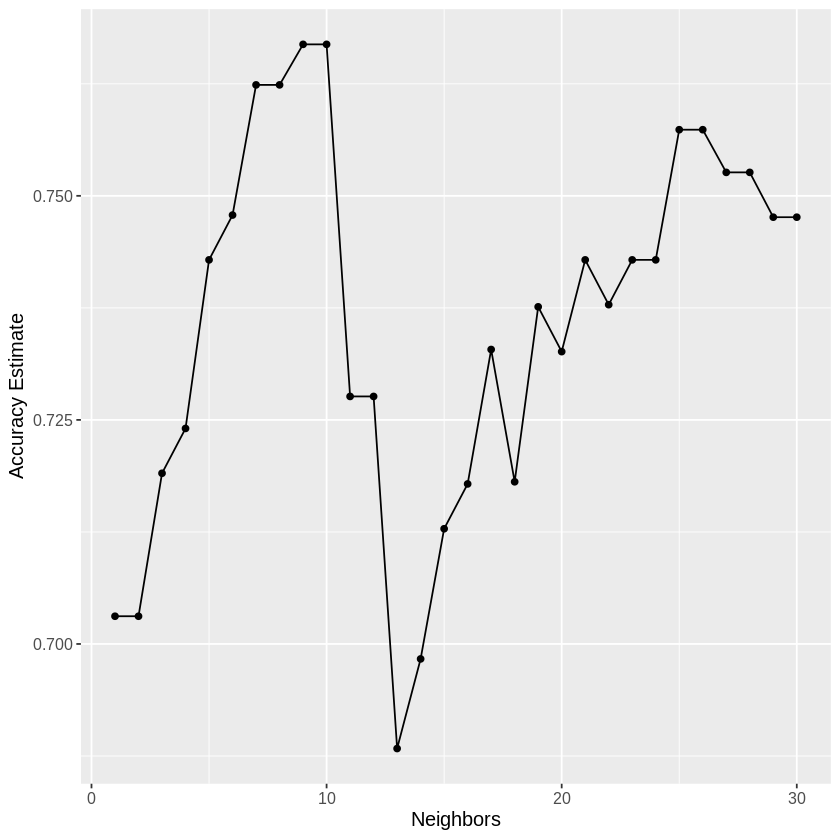

In [25]:
heart_recipe <- recipe(`Heart Disease` ~ Age + `ST depression`, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = `Heart Disease`)

k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

In [28]:
#found the k with most accuracy
maxaccuracies <-accuracies|>arrange(desc(mean))
maxaccuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7669048,10,0.02786257,Preprocessor1_Model09
10,accuracy,binary,0.7669048,10,0.02786257,Preprocessor1_Model10
7,accuracy,binary,0.7623810,10,0.03326107,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,accuracy,binary,0.7030952,10,0.03379508,Preprocessor1_Model02
14,accuracy,binary,0.6983333,10,0.03760272,Preprocessor1_Model14
13,accuracy,binary,0.6883333,10,0.03740521,Preprocessor1_Model13


In [30]:
#predict the test set
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test)

heart_test_predictions |>
  metrics(truth = `Heart Disease`, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- heart_test_predictions |>
  conf_mat(truth = `Heart Disease`, estimate = .pred_class)
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5735294


          Truth
Prediction Presence Absence
  Presence       15      14
  Absence        15      24